In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from utils import create_timeseries_dataset, show_plot, plot_train_history, multi_step_plot

In [34]:
# Reading the Dataset

dataset = pd.read_csv('./dataset-hourly-new-2.csv', usecols=['air_temperature_mean', 'pressure',
                                                           'wind_speed_cos','wind_speed_sin'])
print(f'The Length of data is: {len(dataset)}')
dataset.head()

The Length of data is: 159240


,air_temperature_mean,pressure,wind_speed_cos,wind_speed_sin
0,5.0,987.0,-1.092226,4.571329
1,3.7,988.0,-4.781221,3.283280
2,3.8,988.0,2.225612,-5.355992
3,3.8,988.0,1.136525,6.196637
4,3.6,988.0,1.190645,6.491715


In [35]:
# Spliting into Train and Test set

trainset, testset = train_test_split(dataset, shuffle= False)
print(f'The Length of Train data is: {len(trainset)}')
print(f'The Length of Test data is: {len(testset)}')
trainset.head()

The Length of Train data is: 119430
The Length of Test data is: 39810


,air_temperature_mean,pressure,wind_speed_cos,wind_speed_sin
0,5.0,987.0,-1.092226,4.571329
1,3.7,988.0,-4.781221,3.283280
2,3.8,988.0,2.225612,-5.355992
3,3.8,988.0,1.136525,6.196637
4,3.6,988.0,1.190645,6.491715


In [36]:
# Normalizing and Trasforming the dataset

trainXScaler = MinMaxScaler()
trainYScaler = MinMaxScaler()
testXScaler = MinMaxScaler()
testYScaler = MinMaxScaler()


trainsetX = trainXScaler.fit_transform(trainset)
testsetX = testXScaler.fit_transform(testset)

trainsetY = trainXScaler.fit_transform(trainset['wind_speed'].to_numpy().reshape(-1, 1))
testsetY = testXScaler.fit_transform(testset['wind_speed'].to_numpy().reshape(-1, 1))

KeyError: 'wind_speed'

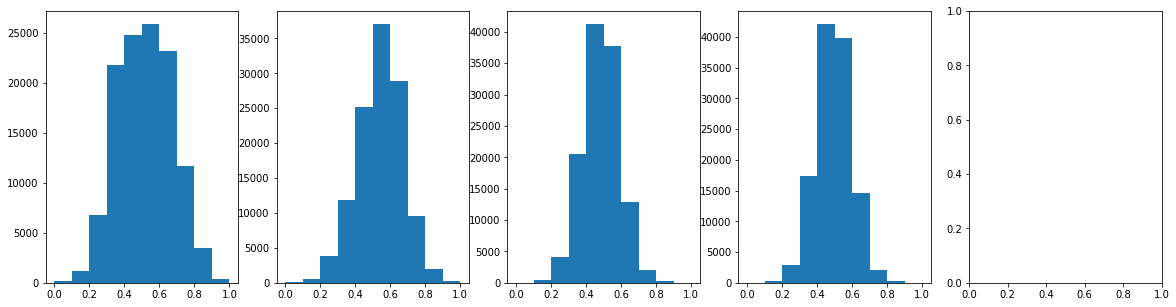

In [37]:
fig, a = plt.subplots(1, 5, figsize=(20,5))
for i in range(len(trainsetX[0])):
    a[i].hist(trainsetX[:,i])
plt.show()

([array([  228.,  1213.,  6783., 21778., 24805., 25893., 23216., 11634.,
          3510.,   370.]),
  array([   98.,   575.,  3832., 11927., 25184., 37068., 28917.,  9628.,
          1988.,   213.]),
  array([4.6000e+01, 4.8300e+02, 4.1880e+03, 2.0548e+04, 4.1273e+04,
         3.7703e+04, 1.2890e+04, 2.0030e+03, 2.7400e+02, 2.2000e+01]),
  array([2.7000e+01, 3.1200e+02, 2.8350e+03, 1.7376e+04, 4.2114e+04,
         3.9816e+04, 1.4546e+04, 2.1540e+03, 2.4000e+02, 1.0000e+01])],
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 4 Lists of Patches objects>)

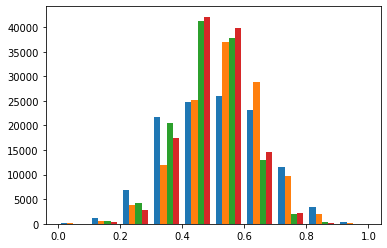

In [38]:
plt.hist(trainsetX)

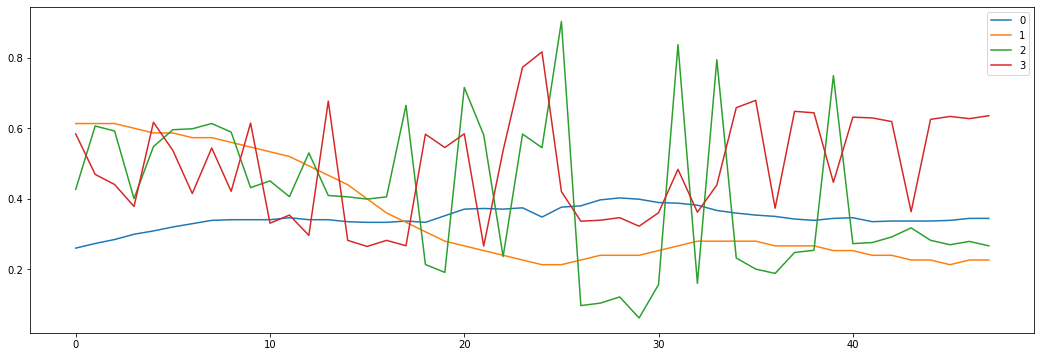

In [39]:
sub_ts = trainsetX[200:248]
plt.figure(figsize=(18, 6))
for i in range(len(sub_ts[0])):
    plt.plot(sub_ts[:, i], label = i)

plt.legend()
plt.show()

In [40]:
# The network is shown data from the last two (2) days
# So, total data point is (2*24)=48 .... past_inputs = 48
# For the multi step prediction model, the label for a datapoint is the temperature 12 hours into the future. 
#... future_outputs = 12

# Machanism of the Model
machanisms = ['cnn', 'lstm', 'cnnlstm', 'convlstm']
machanism = machanisms[2]

# features and target types
multivariate_input = True
multistep_output = True

# features and target counts
input_steps = 1
past_inputs = 48
future_outputs = 12

# Only for ConvLSTM based models, convltsm timestape
convltsm_ts = 2

assert past_inputs % convltsm_ts == 0, "'convltsm_ts' should be a divider of 'past_inputs'"

In [42]:
trainX, trainY = create_timeseries_dataset(trainsetX, trainsetX[:,-1], past_inputs, future_outputs,
                                           input_steps, convltsm_ts, machanism, 
                                           multivariate_input, multistep_output)

testX, testY = create_timeseries_dataset(testsetX, testsetX[:,-1], past_inputs, future_outputs, 
                                         input_steps, convltsm_ts, machanism,
                                         multivariate_input, multistep_output)

print("The shape of Time Series Features",trainX.shape)
print("The shape of Time Series Labels",trainY.shape)

print ('\nSingle window of past history : {}'.format(trainX[0].shape))
print ('Target Wind Speed to predict : {}'.format(trainY[0].shape))

The shape of Time Series Features (119370, 48, 4)
The shape of Time Series Labels (119370, 12, 1)

Single window of past history : (48, 4)
Target Wind Speed to predict : (12, 1)


In [43]:
trainX[0]

array([[0.4082397 , 0.16      , 0.44161719, 0.65986694],
       [0.38389513, 0.17333333, 0.3012674 , 0.61274506],
       [0.38576779, 0.17333333, 0.56784613, 0.29668654],
       [0.38576779, 0.17333333, 0.52641121, 0.71932711],
       [0.38202247, 0.17333333, 0.52847025, 0.73012222],
       [0.37078651, 0.17333333, 0.69615157, 0.48719641],
       [0.36142322, 0.18666667, 0.55616687, 0.32371319],
       [0.37078651, 0.18666667, 0.56492631, 0.3034432 ],
       [0.37453183, 0.2       , 0.57514566, 0.27979488],
       [0.37640449, 0.2       , 0.58536501, 0.25614656],
       [0.38014981, 0.21333333, 0.59412446, 0.23587657],
       [0.37453183, 0.21333333, 0.20090651, 0.67901557],
       [0.37827715, 0.21333333, 0.76780169, 0.44368233],
       [0.38764045, 0.21333333, 0.61748297, 0.18182327],
       [0.37640449, 0.22666667, 0.52984293, 0.73731896],
       [0.36516854, 0.22666667, 0.68496545, 0.70185489],
       [0.3576779 , 0.22666667, 0.61164334, 0.19533659],
       [0.35205992, 0.24      ,

In [44]:
trainY[0]

array([[0.47761635],
       [0.56812152],
       [0.45155662],
       [0.35897847],
       [0.4494503 ],
       [0.44839714],
       [0.58122987],
       [0.59035523],
       [0.6301693 ],
       [0.61931092],
       [0.54539897],
       [0.55142974]])

In [45]:
tf.random.set_seed(13)

In [46]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((testX, testY))
val_data = val_data.batch(BATCH_SIZE).repeat()

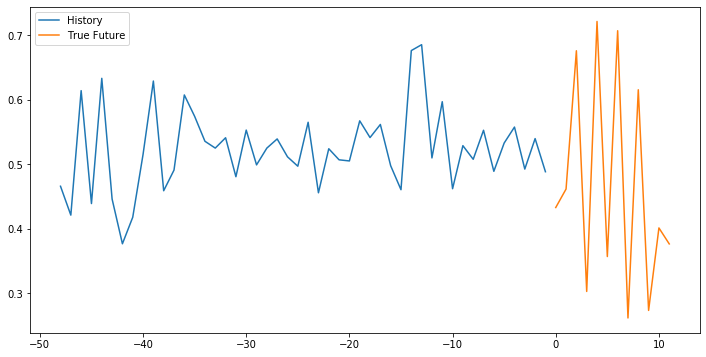

In [48]:
for x, y in val_data.take(1):
    multi_step_plot(x[0], y[0],input_steps, np.array([0]))

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ConvLSTM2D

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=trainX.shape[-2:]))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(RepeatVector(future_outputs))

model.add(LSTM(400, activation='relu', return_sequences=True, dropout=0.4))
model.add(LSTM(200, activation='relu', return_sequences=True, dropout=0.4))

model.add(TimeDistributed(Dense(1)))


model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

In [50]:
for x, y in val_data.take(1):
    print(model.predict(x).shape)

(256, 12, 1)


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 46, 64)            832       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 22, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 128)            0

In [52]:
EPOCHS = 20
EVALUATION_INTERVAL = 250

history = model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=50)

Train for 250 steps, validate for 50 steps
Epoch 1/20
250/250 [==============================] - 73s 293ms/step - loss: 0.0181 - val_loss: 0.0160
Epoch 2/20
250/250 [==============================] - 70s 280ms/step - loss: 0.0101 - val_loss: 0.0154
Epoch 3/20
250/250 [==============================] - 70s 278ms/step - loss: 0.0102 - val_loss: 0.0155
Epoch 4/20
  7/250 [..............................] - ETA: 58s - loss: 0.0103 

KeyboardInterrupt: 

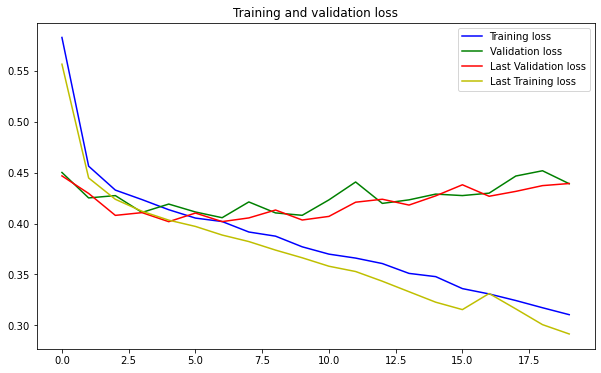

In [65]:
plot_train_history(history,'Training and validation loss',previous_loss=previous_loss, previous_val=previous_val)

In [54]:
previous_loss = history.history['loss']
previous_val = history.history['val_loss']

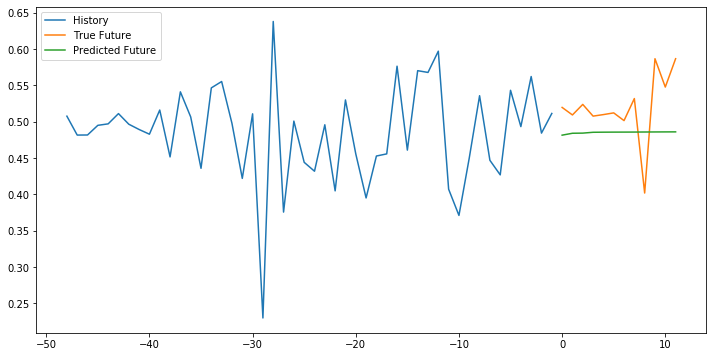

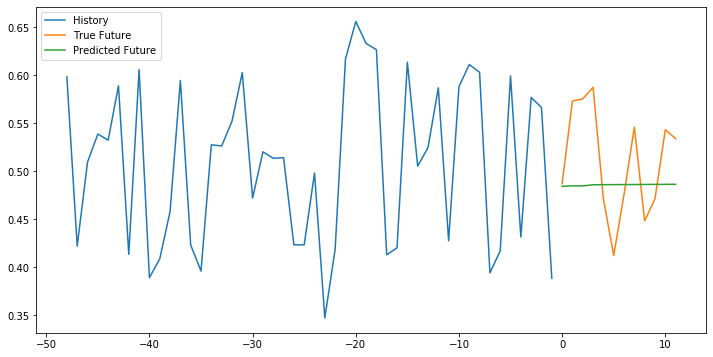

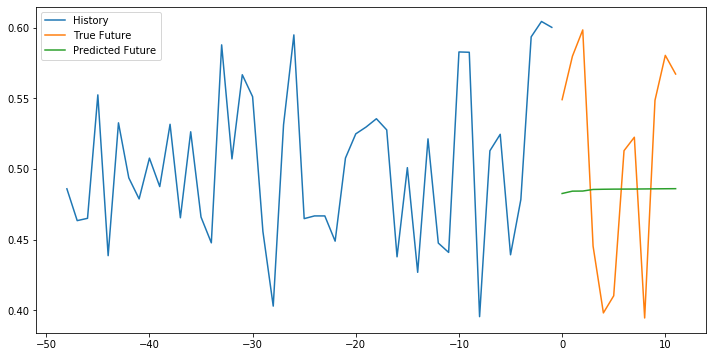

In [53]:
for x, y in train_data.take(3):
    multi_step_plot(x[0], y[0], input_steps, model.predict(x)[0])

In [ ]:
model.save('model.h5')

In [ ]:
predicted, real = model.predict(np.array([testX[0]])), testY[0]

In [ ]:
testScaler.inverse_transform(predicted.reshape((predicted.shape[-2:])))